## Estudio del pico y mejora del RF

### 1. Estudio del pico en el espectro de energías

Vamos a investigar el pico extraño que salía en los resultados anteriores del regressor de energía entrenado con datos reales para comprobar el origen de esa extrañeza. De la última sesión dedujimos que tendría que ver con el trigger type o uct trigger type, que contienen datos sobre si los sucesos reales son realmente eventos de calibración del telescopio y en caso afirmativo, entrenar el modelo sin esos datos ya que no son sucesos reales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader, read_table
import scipy

# RandomForest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Distribución del clasificador
import scipy.stats as stats

/tmp/ipykernel_971/1269661234.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            #'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realR = tb[features]
df_realR = df_realR.dropna()
df_realR = df_realR[(df_realR['intensity']>200)]

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realR.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

XrealR = df_realR

In [3]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g2:
    gamma_tel_events2 = loader_g2.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]

gamma_tel_events_f = gamma_tel_events[features]
gamma_tel_events_f2 = gamma_tel_events2[features]

# Convertimos a dataframe
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]
df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los dataframes
df_gammaT = pd.concat([df_gamma, df_gamma2], axis=0)   

X = df_gamma.drop("true_energy", axis=1)                                              # Determina los parámetros 
y = df_gamma["true_energy"]

In [4]:
rf = RandomForestRegressor(n_estimators=125)
rf.fit(X, y)

RandomForestRegressor(n_estimators=125)

In [5]:
# Hacemos predicciones con el modelo:
y_pred = rf.predict(XrealR)

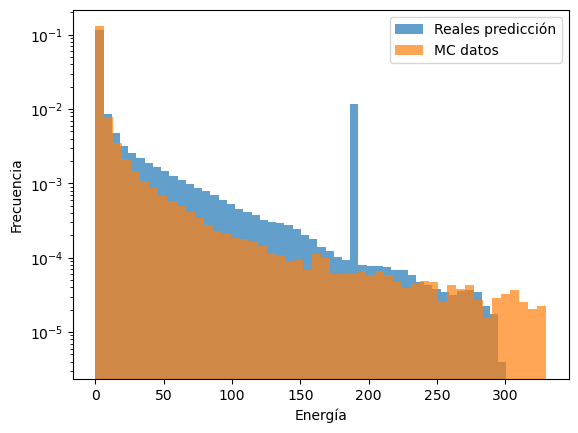

In [6]:
# Representamos ahora como es el espectro de los dos
plt.hist(y_pred, bins=50, density=True, alpha = 0.7, label = "Reales predicción")
plt.hist(y, bins=50, density=True, alpha = 0.7, label = "MC datos")
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.legend()
plt.show()

Se observa claramente un pico que resalta por encima de los demás, con una energía de 150-200 y es lo que vamos a investigar. Para ello, hay que extraer la población que pertenece a este grupo y extraer otras dos poblaciones también para comprobar que el trigger type es diferente con respecto a esta población de estudio.

Primero de todo, debemos repetir la extracción de datos pero ahora cogiendo también el tigger type. Luego haremos el mismo histograma para la predicción de energías para datos reales pero poniendo de leyenda el valor de trigger type y así podremos ver si esa población es diferente al resto.

In [7]:
# Cargamos las imágenes REALES con TRIGGER TYPE
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            'trigger_type',
            'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

In [8]:
df_realR = tb[features]
df_realR = df_realR.dropna()
df_realR = df_realR[(df_realR['intensity']>200)]

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realR.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

XrealR = df_realR.drop("trigger_type", axis=1)
XrealR = XrealR.drop("ucts_trigger_type", axis=1)
XrealR = XrealR.drop("event_type", axis=1)
yrealR_trigger_type = df_realR["trigger_type"]
yrealR_ucts_trigger_type = df_realR["ucts_trigger_type"]
yrealR_event_type = df_realR["event_type"]

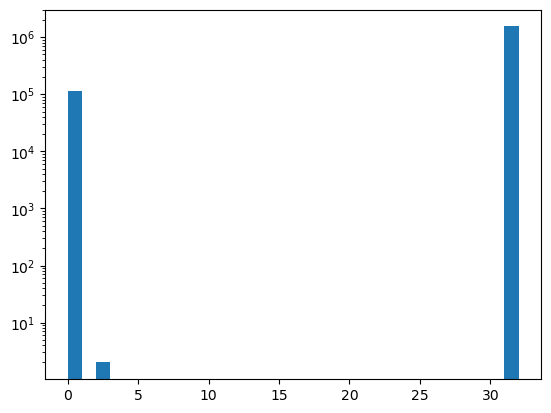

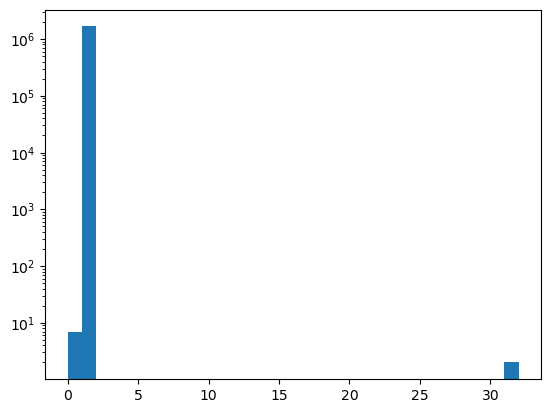

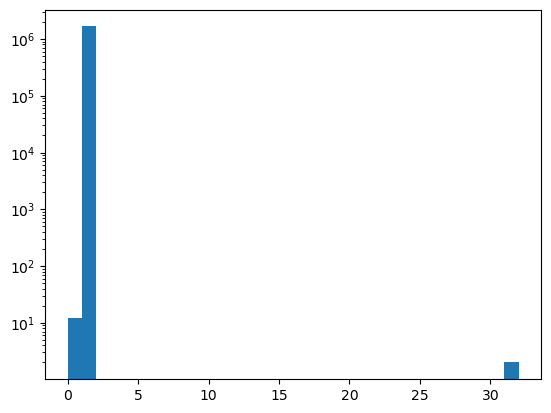

In [9]:
plt.hist(yrealR_event_type, bins=32)
plt.yscale('log')
plt.show()

plt.hist(yrealR_trigger_type, bins=32)
plt.yscale('log')
plt.show()

plt.hist(yrealR_ucts_trigger_type, bins=32)
plt.yscale('log')
plt.show()

En vista de estos resultados, un pico tan prominente solo puede ser causado por event_type

In [10]:
# Pasamos nuestra label a array
yrealR_event_type = yrealR_event_type.values

# Juntamos y_pred y label para obtener una matriz
y_pred_label = np.vstack((y_pred, yrealR_event_type))
print(y_pred_label)

[[1.44578534e+02 7.90830738e-02 3.82228736e-01 ... 7.12133636e-01
  1.02596847e-01 4.90631835e-01]
 [3.20000000e+01 3.20000000e+01 3.20000000e+01 ... 3.20000000e+01
  3.20000000e+01 3.20000000e+01]]


In [11]:
val32 = []
val0 = []
val2 = []
# Creamos 3 arrays que nos dividen los datos según el event_type
for j in range(len(y_pred)):
    if y_pred_label[1,j] > 2:
        val32.append(y_pred_label[0,j])
    elif y_pred_label[1,j] < 2:
        val0.append(y_pred_label[0,j])
    else:
        val2.append(y_pred_label[0,j])

print(len(val32))
print(len(val0))
print(len(val2))

1545759
114421
2


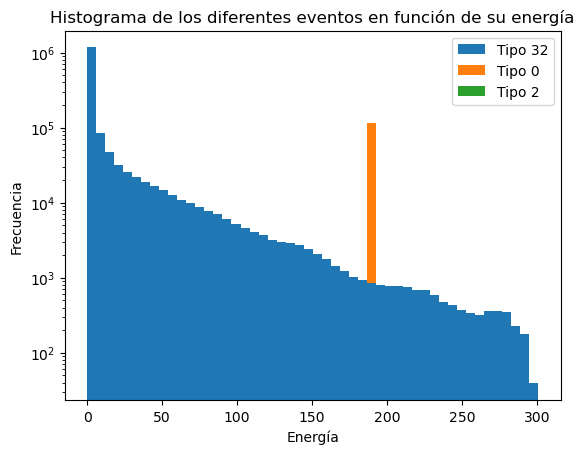

In [12]:
plt.hist([val32, val0, val2], bins=50, stacked=True, label=['Tipo 32', 'Tipo 0', 'Tipo 2'])

plt.yscale('log')
plt.xlabel('Energía')
plt.ylabel('Frecuencia')
plt.title('Histograma de los diferentes eventos en función de su energía')
plt.legend()
plt.show()

Claramente el pico se debe a los eventos de tipo 0, por lo que a partir de ahora los dejaremos de lado para entrenar nuestros modelos ya que se tratan de eventos no correspondientes a EAS sino probablemente a los eventos de calibración.

Vamos a repetir los modelos anteriores pero ahora utilizando unicamente val32 y dejando de lado val0 y val2 para nuestros datos reales.

### 2. Modelo RF mejorado: datos reales filtrados

#### 2.1. RF Regressor de energías con corte de intensidad

In [17]:
# Cargamos las imágenes REALES con TRIGGER TYPE
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

In [18]:
# Sacamos nuestro dataframe de datos reales con la columna extra de event_type
df_realR = tb[features]
df_realR = df_realR.dropna()
df_realR = df_realR[(df_realR['intensity']>200)]

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realR.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realR = df_realR[(df_realR['event_type'] >= 2)]

# Eliminamos la columna de event_type del dataframe ya filtrado y ya tendríamos nuestros datos para el modelo
XrealR = df_realR.drop("event_type", axis=1)

In [19]:
# Hacemos predicciones con el modelo con los datos ya buenos:
y_pred = rf.predict(XrealR)

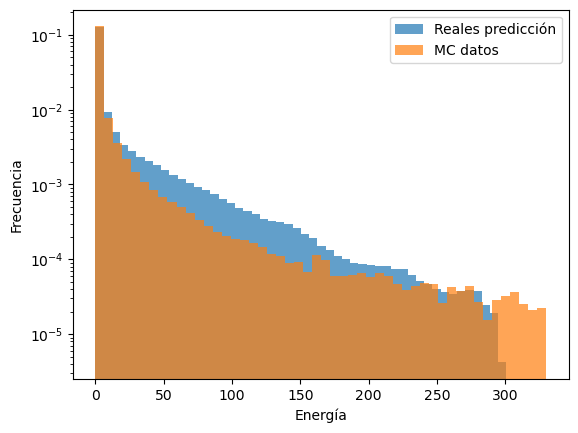

In [20]:
# Representamos ahora como es el espectro de los dos
plt.hist(y_pred, bins=50, density=True, alpha = 0.7, label = "Reales predicción")
plt.hist(y, bins=50, density=True, alpha = 0.7, label = "MC datos")
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Energía')
plt.legend()
plt.show()

Como se puede comprobar, los datos del pico ya han desaparecido completamente y el modelo se ajusta mucho mejor al espectro de energías de los datos simulados

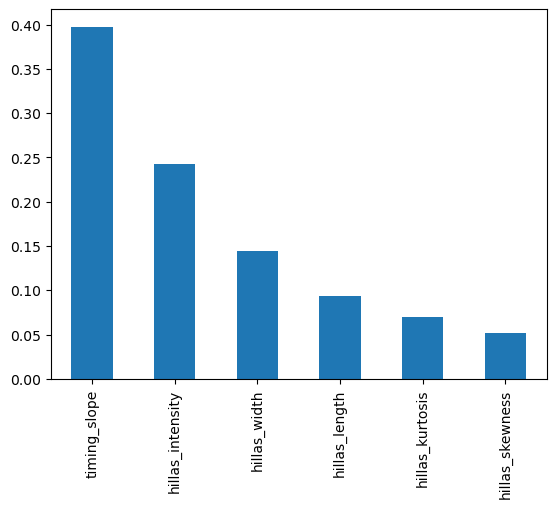

In [21]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

#### 2.2 RF Classifier de gammas y protones entrenado con MC y probado por reales

In [22]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_protons)):
    label.append(1)                                                                   # Nombramos los protones como 1
for i2 in range(len(df_protons2)):
    label.append(1)
for j in range(len(df_gamma)):
    label.append(0)                                                                   # Nombramos los gamma como 0
for j2 in range(len(df_gamma2)):
    label.append(0)
    
df_protongamma.insert(6,"label", label, True)

Xc = df_protongamma.drop("label", axis=1)                                              # Determina los parámetros 
yc = df_protongamma["label"]

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
df_realC = df_realC[(df_realC['intensity']>200)]

# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]

# Eliminamos la columna de event_type del dataframe ya filtrado y ya tendríamos nuestros datos para el modelo
XrealC = df_realC.drop("event_type", axis=1)
XrealC = XrealC.drop("gammaness", axis=1)
yrealC = df_realC["gammaness"]

In [23]:
rfC = RandomForestClassifier(max_depth=19, n_estimators=150)
rfC.fit(Xc, yc)

RandomForestClassifier(max_depth=19, n_estimators=150)

In [24]:
y_pred = (rfC.predict_proba(XrealC))
proba = y_pred[:,0]

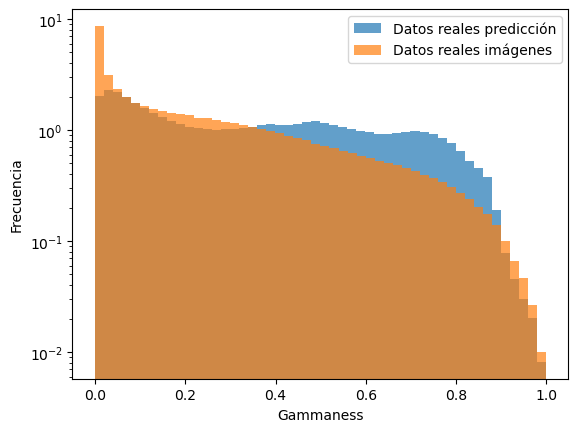

In [25]:
# Representamos ahora cómo es el espectro de las predicciones
plt.hist(proba, bins=50, density=True, alpha = 0.7, label = "Datos reales predicción")
plt.hist(yrealC, bins=50, density=True, alpha = 0.7, label = "Datos reales imágenes")
plt.yscale('log')
plt.ylabel('Frecuencia')
plt.xlabel('Gammaness')
plt.legend()
plt.show()

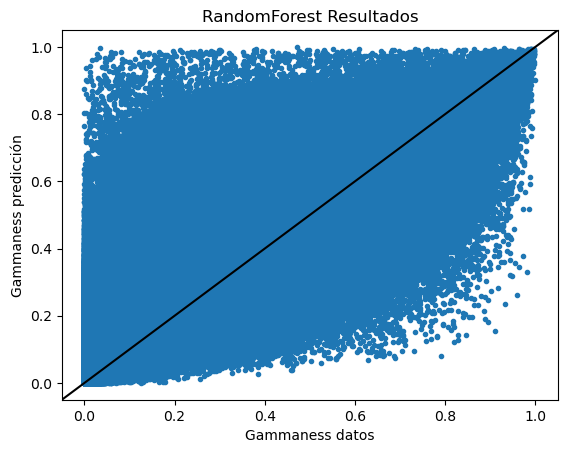

In [26]:
plt.plot(yrealC, proba, ".")
plt.axline((1, 1), slope=1, c="k")

plt.title("RandomForest Resultados")
plt.xlabel('Gammaness datos')
plt.ylabel('Gammaness predicción')

plt.show()

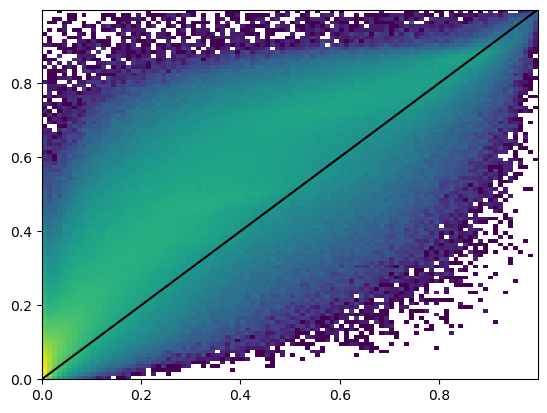

In [31]:
from matplotlib import colors
plt.hist2d(yrealC, proba, bins=100, norm = colors.LogNorm())
plt.axline((1, 1), slope=1, c="k")
plt.show()

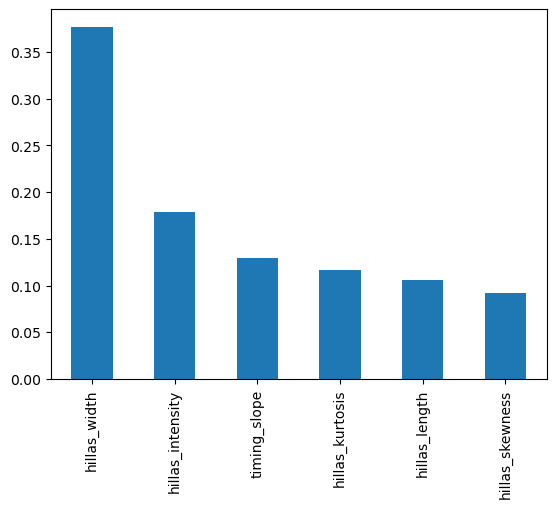

In [28]:
feature_importances = pd.Series(rfC.feature_importances_, index=Xc.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

#### 2.3 RF Classifier de MC y Reales

In [33]:
# Cargamos imágenes SIMULADAS
with TableLoader("../datos/proton.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=1647471)
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

with TableLoader("../datos/proton_with_images_00.dl2.h5", load_dl1_images=True, load_dl2=True,load_simulated=True) as loader_p:
    protons_tel_events2 = loader_p.read_telescope_events("LST_LST_LSTCam", start=0, stop=82178)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events2 = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=33922
)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 #'true_energy'
]

protons_tel_events_f = protons_tel_events[features] 
gamma_tel_events_f=gamma_tel_events[features]
protons_tel_events_f2 = protons_tel_events2[features] 
gamma_tel_events_f2=gamma_tel_events2[features]

# Convertimos a dataframe
df_protons = protons_tel_events_f.to_pandas()
df_protons = df_protons.dropna()
df_protons = df_protons[(df_protons['hillas_intensity']>200)]

df_protons2 = protons_tel_events_f2.to_pandas()
df_protons2 = df_protons2.dropna()
df_protons2 = df_protons2[(df_protons2['hillas_intensity']>200)]

df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma = df_gamma[(df_gamma['hillas_intensity']>200)]

df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()
df_gamma2 = df_gamma2[(df_gamma2['hillas_intensity']>200)]

# Juntamos los cuatro dataframe
df_protongamma = pd.concat([df_protons, df_protons2, df_gamma, df_gamma2], axis=0)

# Cargamos las imágenes REALES
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"
file = "../datos/dl2_LST-1.Run02949.h5"
tb = pd.read_hdf(file, tablename)

# Las columnas deben estar en el mismo orden que en el fit (las de MC)
features = [
            #'obs_id',
            #'event_id',
            'intensity',
            'skewness',
            'kurtosis',
            #'log_intensity',
            #'x',
            #'y',
            #'r',
            #'phi',
            'length',
            #'length_uncertainty',
            'width',
            #'width_uncertainty',
            #'psi',
            'time_gradient',
            #'intercept',
            #'leakage_intensity_width_1',
            #'leakage_intensity_width_2',
            #'leakage_pixels_width_1',
            #'leakage_pixels_width_2',
            #'n_pixels',
            #'concentration_cog',
            #'concentration_core',
            #'concentration_pixel',
            #'n_islands',
            #'alt_tel',
            #'az_tel',
            #'calibration_id',
            #'dragon_time',
            #'ucts_time',
            #'tib_time',
            #'ucts_jump',
            #'mc_type',
            #'wl',
            #'tel_id',
            #'tel_pos_x',
            #'tel_pos_y',
            #'tel_pos_z',
            #'trigger_type',
            #'ucts_trigger_type',
            #'trigger_time',
            'event_type',
            #'delta_t',
            #'log_reco_energy',
            #'reco_energy',
            #'reco_disp_norm',
            #'reco_disp_sign',
            #'reco_disp_dx',
            #'reco_disp_dy',
            #'reco_src_x',
            #'reco_src_y',
            #'signed_time_gradient',
            #'signed_skewness',
            #'reco_alt',
            #'reco_az',
            #'reco_type',
            #'gammaness'
            ]

df_realC = tb[features]
df_realC = df_realC.dropna()
df_realC = df_realC[(df_realC['intensity']>200)]
# Debemos cambiar el nombre de las features para que sean el mismo que el de MC ya que sino el RF no sabrá cuál es cuál
df_realC.rename(columns={'intensity': 'hillas_intensity', 'length': 'hillas_length', 'width': 'hillas_width', 'skewness': 'hillas_skewness',
                        'kurtosis': 'hillas_kurtosis', 'time_gradient': 'timing_slope'}, inplace=True)

# Filtramos nuestro dataframe para únicamente los eventos de tipo 32 y 2 (nos quita los eventos de tipo 1)
df_realC = df_realC[(df_realC['event_type'] >= 2)]
df_realC = df_realC.drop("event_type", axis=1)

# Dataframe de datos simulados
df_simu = df_protongamma
df_real = df_realC

# Creamos la etiqueta para que el modelo pueda comprobar sus resultados
label = []                                                                                             
for i in range(len(df_simu)):
    label.append(1)                                                                   # Nombramos los simulados como 1
for j in range(len(df_real)):
    label.append(0)                                                                   # Nombramos los reales como 0

# Los concatenamos para juntar todos los datos en el mismo dataframe
df_simureal = pd.concat([df_simu, df_real], axis=0)

df_simureal.insert(6,"label", label, True)

X = df_simureal.drop("label", axis=1)                                              # Determina los parámetros 
y = df_simureal["label"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rfrs = RandomForestClassifier(max_depth=19, n_estimators=150)
rfrs.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, n_estimators=150)

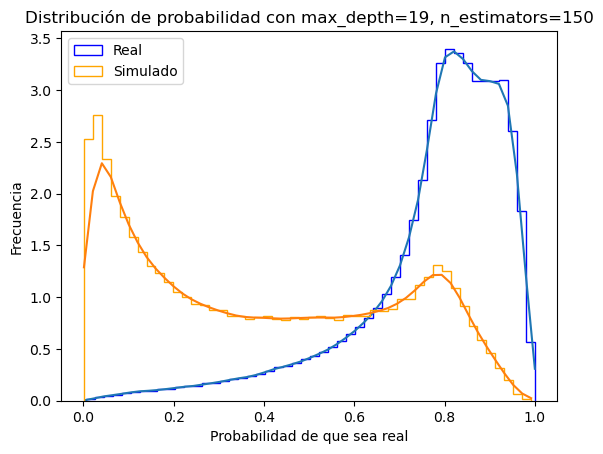

In [35]:
y_pred = (rfrs.predict_proba(X_test))
proba = y_pred[:,0]                                                                             # Probabilidad de que el suceso sea un gamma
label = y_test                                                                                   # Etiqueta real del suceso
    
# Asignamos a cada probabilidad que devuelve el RF la etiqueta real del suceso
prob_real = proba[label == 0]
prob_simu = proba[label == 1]

densityr = stats.gaussian_kde(prob_real)
nr, xr, _ = plt.hist(prob_real, bins=50, density=True, histtype=u'step', color = 'blue', label='Real')  
plt.plot(xr, densityr(xr))

densitys = stats.gaussian_kde(prob_simu)
ns, xs, _ = plt.hist(prob_simu, bins=50, density=True, histtype=u'step', color = 'orange', label='Simulado')  
plt.plot(xs, densitys(xs))

plt.title("Distribución de probabilidad con max_depth=19, n_estimators=150")
plt.xlabel("Probabilidad de que sea real")
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

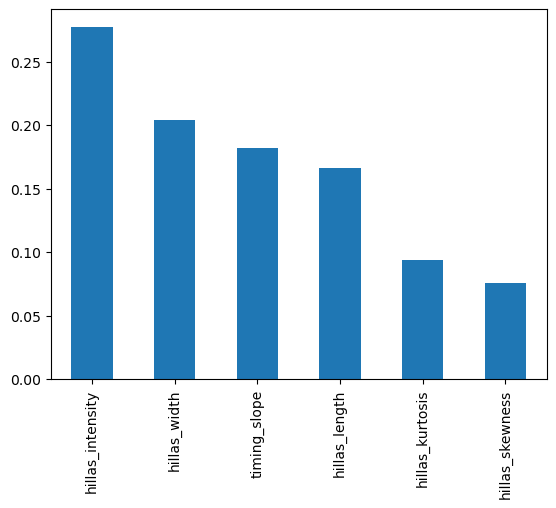

In [36]:
feature_importances = pd.Series(rfrs.feature_importances_, index=X_test.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

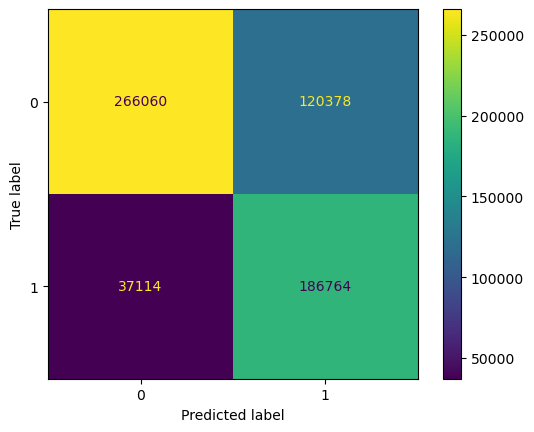

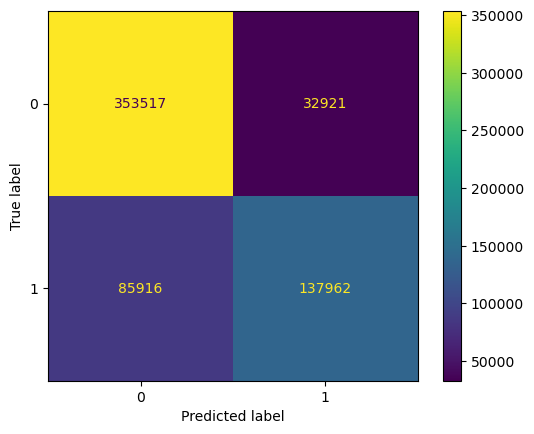

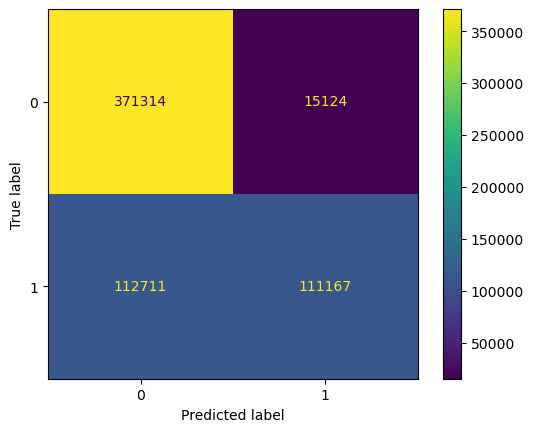

In [37]:
y_pred = (rfrs.predict_proba(X_test)[:,1]>0.25).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rfrs.predict_proba(X_test)[:,1]>0.5).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

y_pred = (rfrs.predict_proba(X_test)[:,1]>0.65).astype("float")             # Hacemos que solamente nos devuelva los valores del threshold
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

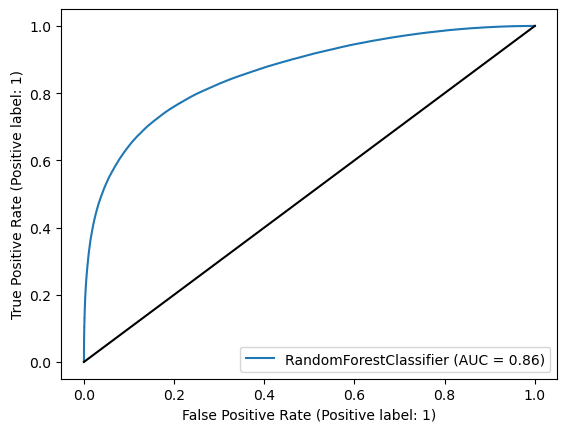

In [38]:
from sklearn.metrics import RocCurveDisplay, auc

# Representamos la curva ROC (para protones y gammas)
ax = plt.gca()
rf_ROC_disp = RocCurveDisplay.from_estimator(rfrs, X_test, y_test, ax=ax)

ident = [0.0, 1.0]
plt.plot(ident,ident,"k", label="ROC Random")
plt.show()